In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("quant-quinn-server-result/Apr-23-2021.csv", index_col=0)
#train_df = pd.read_csv("server3_processed.csv")
train_df.head()

Implementation    Mode  \
Run                                                              
0     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
1     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
2     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
3     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
4     cargo run --example server /QUIC-Ivy/doc/exam...  server   

                     TestName  Status                ErrorIEV  \
Run                                                             
0    quic_server_test_stream0     NaN                     NaN   
1    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
2    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
3    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
4    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
0    /home/student/Toward-verification-of-QUIC-exte...        0.0     1.0  
1    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
2    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
3    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
4    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0

In [3]:
#       ['quic_server_test_stream', 'quic_server_test_unkown',
#       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
#       'quic_server_test_token_error', 'quic_server_test_tp_error',
#       'quic_server_test_tp_acticoid_error',
#       'quic_server_test_connection_close',
#       'quic_server_test_reset_stream',
#       'quic_server_test_handshake_done_error',
#       'quic_server_test_stop_sending',
#       'quic_server_test_double_tp_error',
#       'quic_server_test_tp_limit_acticoid_error',
#       'quic_server_test_no_icid', 'quic_server_test_ext_min_ack_delay']

for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
        
train_df = train_df[train_df.Mode != 'client']
train_df = train_df[train_df.TestName != 'quic_server_test_tp_limit_acticoid_error']

train_df.head()

Implementation    Mode  \
Run                                                              
0     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
1     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
2     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
3     ./server -d /QUIC-Ivy/doc/examples/quic/ -c /...  server   
4     cargo run --example server /QUIC-Ivy/doc/exam...  server   

                    TestName  Status                ErrorIEV  \
Run                                                            
0    quic_server_test_stream     NaN                     NaN   
1    quic_server_test_stream     NaN  ivy_return_code(1)+"")   
2    quic_server_test_stream     NaN  ivy_return_code(1)+"")   
3    quic_server_test_stream     NaN  ivy_return_code(1)+"")   
4    quic_server_test_stream     NaN  ivy_return_code(1)+"")   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
0    /home/student/Toward-verification-of-QUIC-exte...        0.0     1.0  
1    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
2    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
3    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
4    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0

In [4]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run --manifest-path=tools/apps/Cargo.toml" in s:
        servers.append("quiche")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quiche")
    if "cargo run --example server" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")

print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)

train_df.head()

['quant', 'quinn']


Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1            quant  server  quic_server_test_stream     NaN   
2            quant  server  quic_server_test_stream     NaN   
3            quant  server  quic_server_test_stream     NaN   
4            quinn  server  quic_server_test_stream     NaN   

                   ErrorIEV  \
Run                           
0                       NaN   
1    ivy_return_code(1)+"")   
2    ivy_return_code(1)+"")   
3    ivy_return_code(1)+"")   
4    ivy_return_code(1)+"")   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
0    /home/student/Toward-verification-of-QUIC-exte...        0.0     1.0  
1    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
2    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
3    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0  
4    /home/student/Toward-verification-of-QUIC-exte...        0.0     0.0

In [5]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile =  row["OutputFile"][77:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_server_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(1)+value(" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif 'ivy_return_code(1)' in content:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "timeout+" in row["ErrorIEV"] :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'ivy_return_code(1)' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")

In [6]:
# Preprocess multiple output possible
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_token_error']
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_token_error':
        if row["ErrorIEV"] == "Handshake not completed":
            train_df.loc[i, "isPass"] = 1.0
            #train_df.loc[i, "ErrorIEV"] = "No Error"
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_double_tp_error':
        if row["ErrorIEV"] == "Handshake not completed":
            train_df.loc[i, "isPass"] = 1.0
            #train_df.loc[i, "ErrorIEV"] = "No Error"
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_unkown':
        if "frame.connection_close:{err_code:0x7}" in row["ErrorIEV"]:
            train_df.loc[i, "isPass"] = 1.0
            train_df.loc[i, "ErrorIEV"] = "No Error"
print(train_df.head())

    Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1            quant  server  quic_server_test_stream     NaN   
2            quant  server  quic_server_test_stream     NaN   
3            quant  server  quic_server_test_stream     NaN   
4            quinn  server  quic_server_test_stream     NaN   

                                              ErrorIEV  \
Run                                                      
0                                             No Error   
1    require ~_generating & ~queued_non_ack(scid) -...   
2    require ~_generating & ~queued_non_ack(scid) -...   
3                              Handshake not completed   
4    require conn_seen(dcid) -> hi_non_probing_endp...   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        

In [7]:
print(train_df["ErrorIEV"].unique().tolist())
print(train_df.head())

['No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_frame_encoding_error;"', 'require ~path_challenge_pending(dcid,f.data);"', 'server_return_code(1)+timeout', 'require conn_total_data(the_cid) > 0;"', 'frame.connection_close:{err_code:0x5}', 'require stream_id_allowed(dcid,f.id);  # [6]"', 'require is_protocol_violation"', 'Segmentation Fault 134', 'frame.connection_close:{err_code:0x7}', 'require ~draining_pkt_sent(scid) & queued_close(scid);"']
    Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1            quant  server  quic_server_test_stream     NaN   
2            quant  server  quic_server_test_stream     NaN   
3            quant  server  quic_server_test_stream     NaN   
4            qu

In [8]:
train_df.TestName.unique()

array(['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_blocked_streams_maxstream_error',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_retirecoid_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_double_tp_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream'], dtype=object)

In [14]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "server-result-3/temp/" + str(i) + "_quic_server_" + str(row["TestName"])  + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server3_processed.csv",index=False)
    j += size
    

train_df.head()

4200
420
10



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


Implementation    Mode                           TestName  Status  \
Run                                                                     
2            quant  server  quic_server_test_connection_close     NaN   
5          quic-go  server  quic_server_test_connection_close     NaN   
8          quic-go  server  quic_server_test_connection_close     NaN   
11         quic-go  server  quic_server_test_connection_close     NaN   
14         quic-go  server  quic_server_test_connection_close     NaN   

                    ErrorIEV  \
Run                            
2    Handshake not completed   
5    Handshake not completed   
8    Handshake not completed   
11   Handshake not completed   
14   Handshake not completed   

                                            OutputFile  NbPktSend  isPass  
Run                                                                        
2    /results/temp/355/quic_server_test_connection_...       15.0     0.0  
5    /results/temp/405/quic_server_test_connection_...       16.0     0.0  
8    /results/temp/406/quic_server_test_connection_...       10.0     0.0  
11   /results/temp/456/quic_server_test_connection_...       17.0     0.0  
14   /results/temp/457/quic_server_test_connection_...        7.0     0.0

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


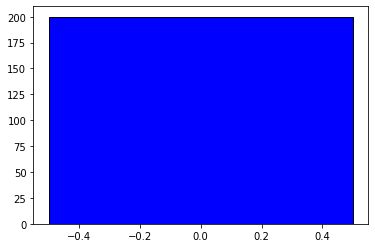

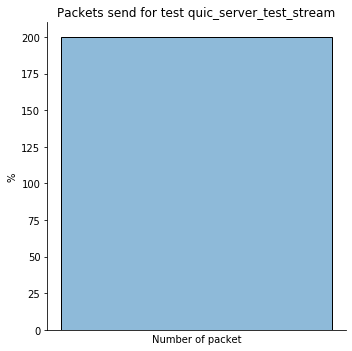

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


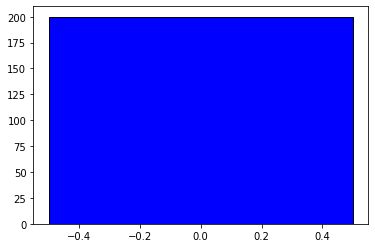

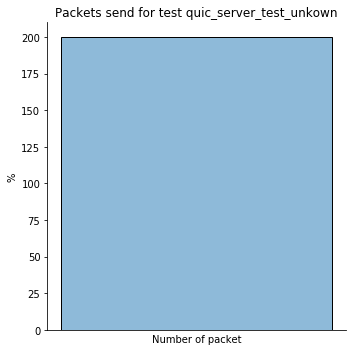

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


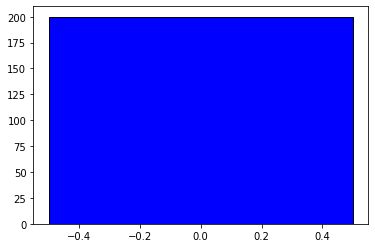

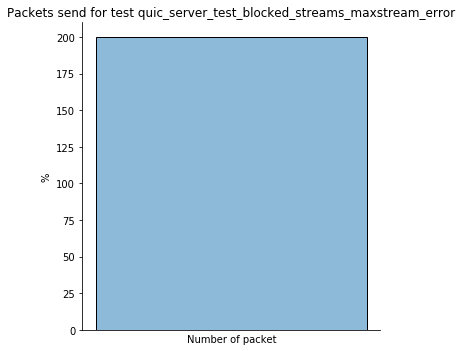

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


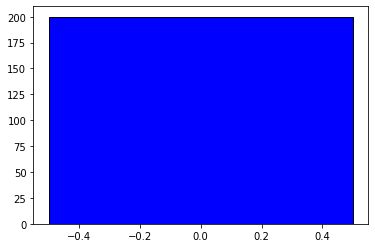

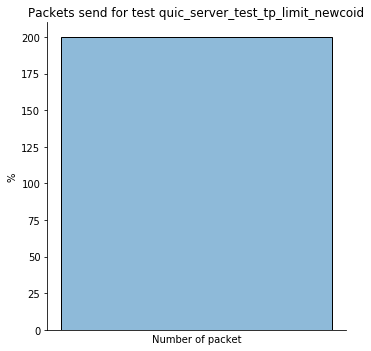

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


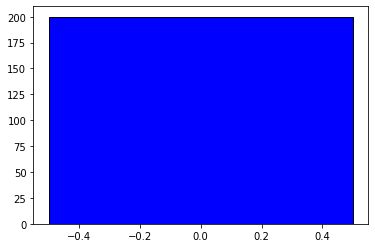

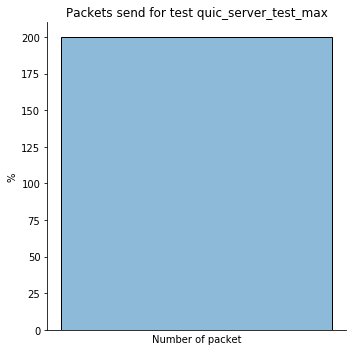

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


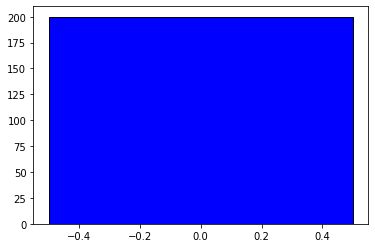

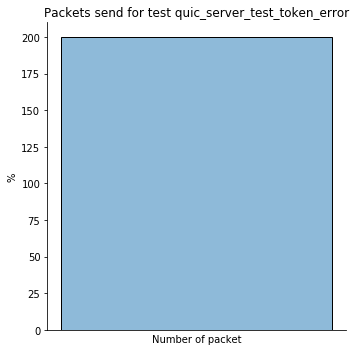

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


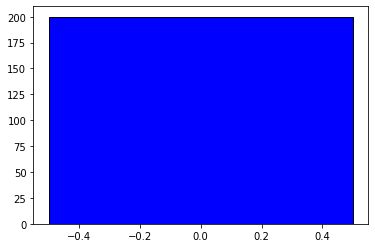

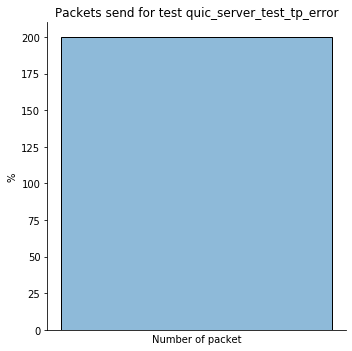

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


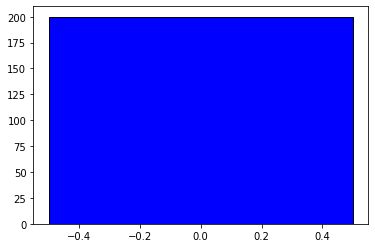

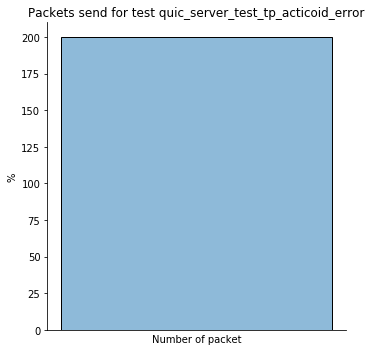

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


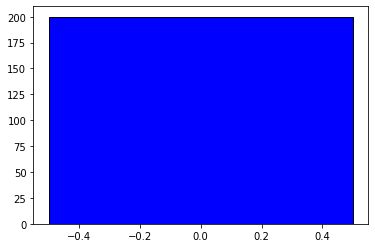

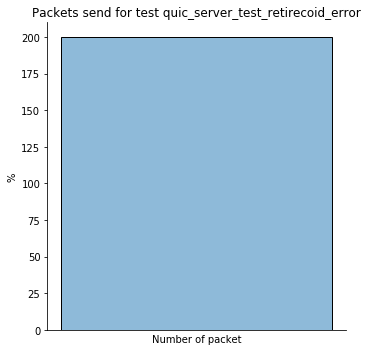

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


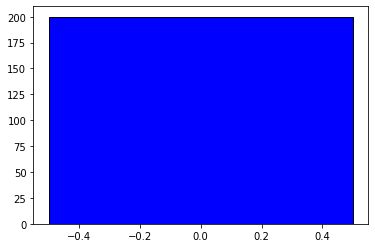

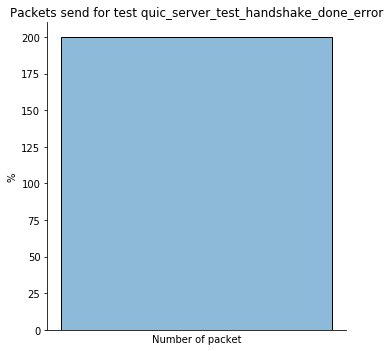

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


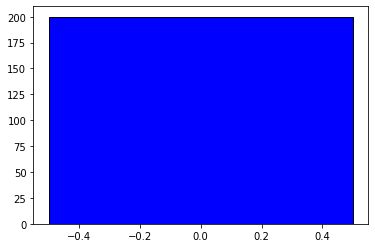

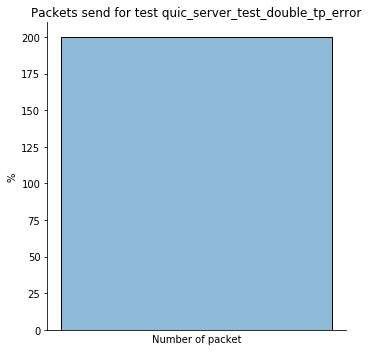

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


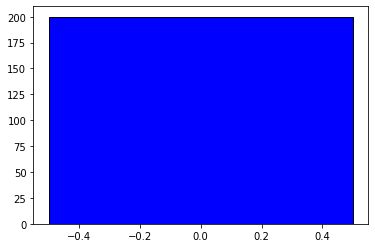

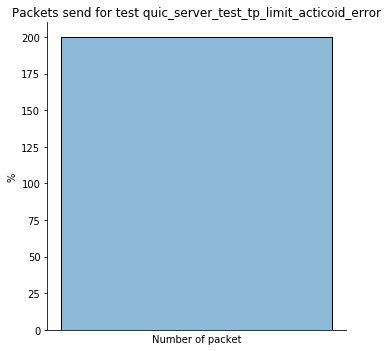

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


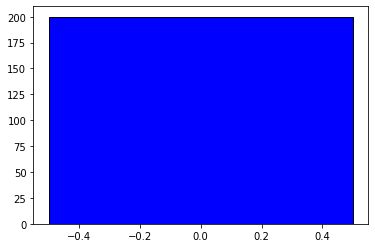

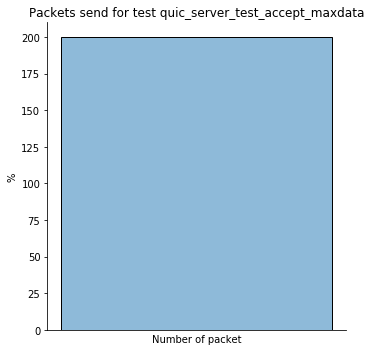

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


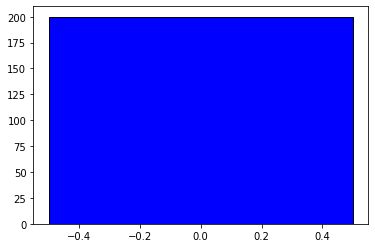

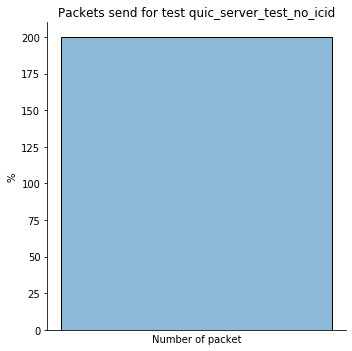

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


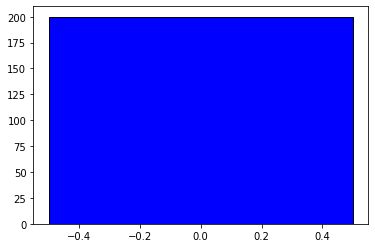

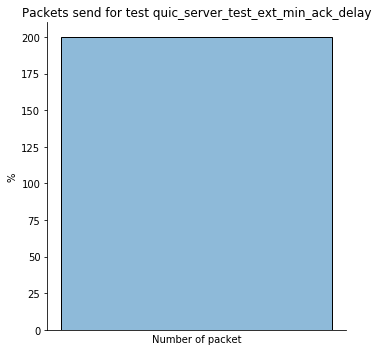

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


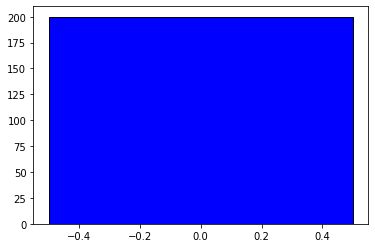

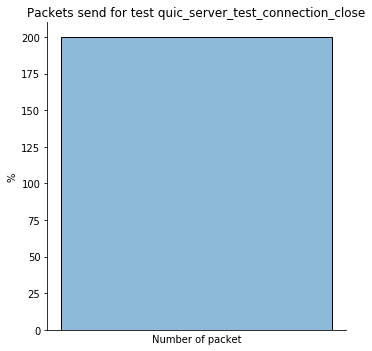

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


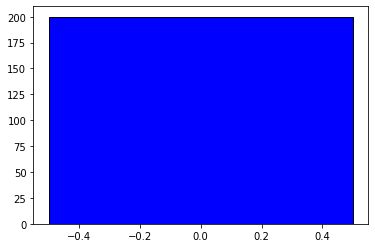

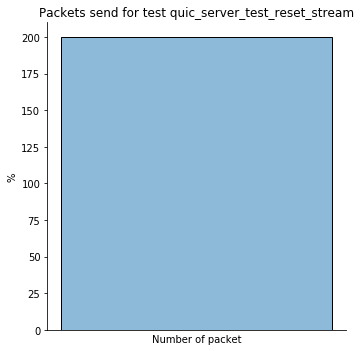

In [56]:
# Failure per test

tests = train_df.TestName.unique()

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    plt.savefig(filename)
    plt.show()

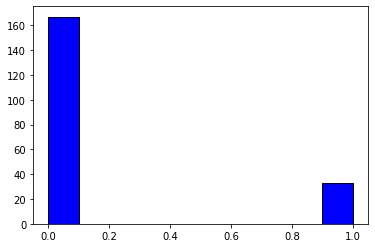

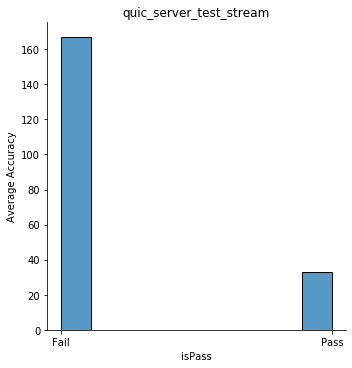

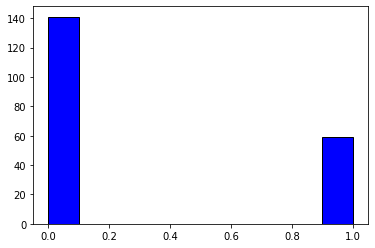

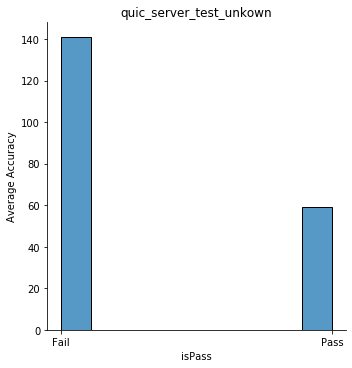

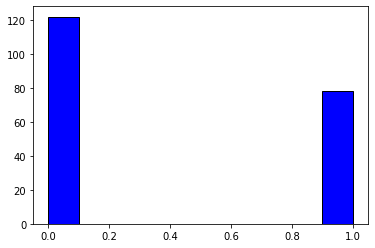

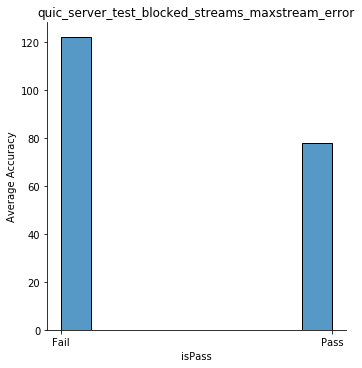

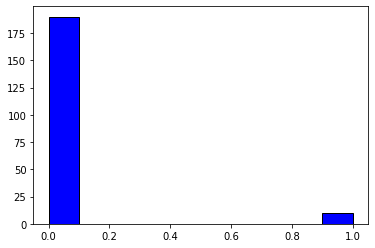

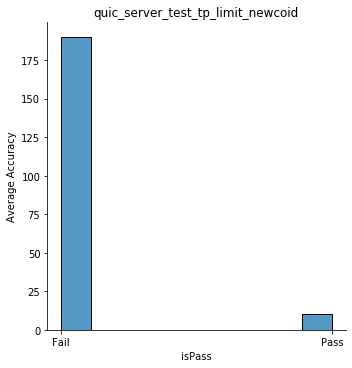

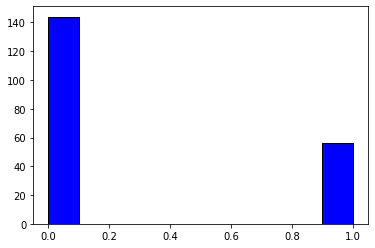

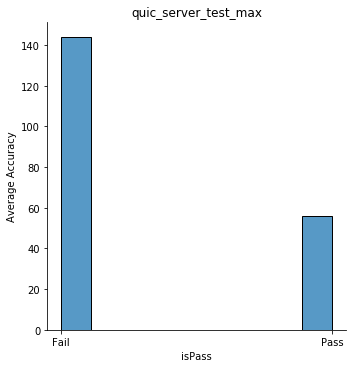

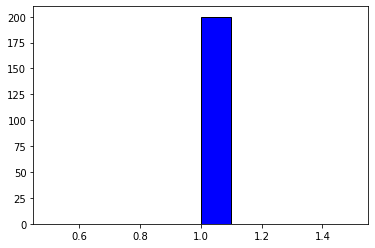

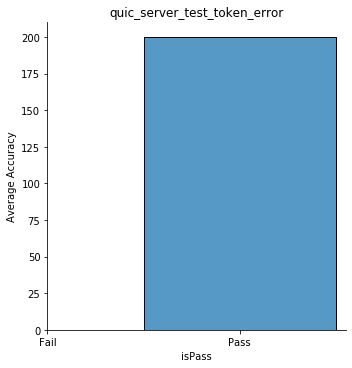

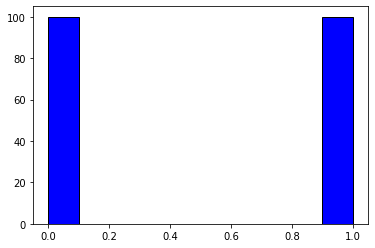

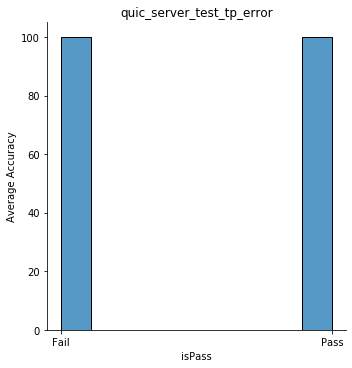

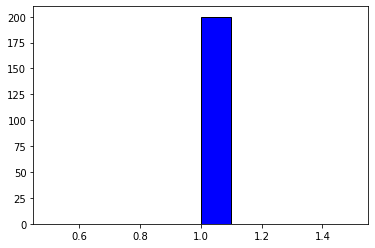

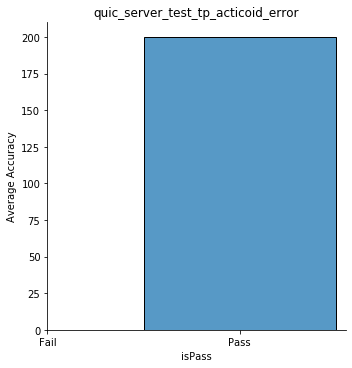

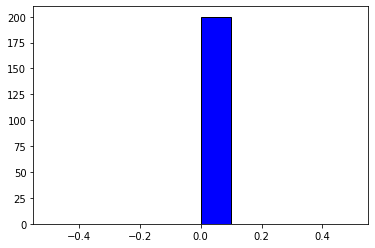

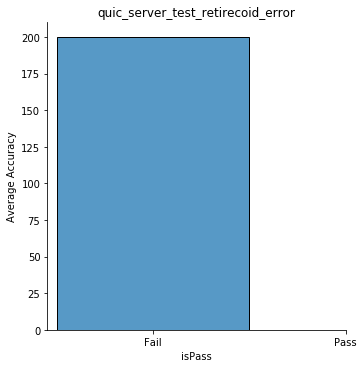

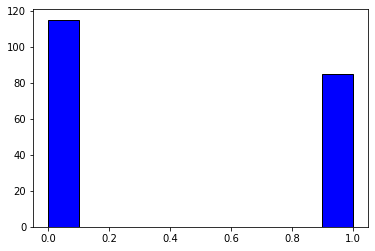

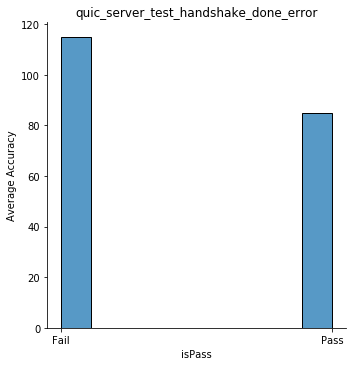

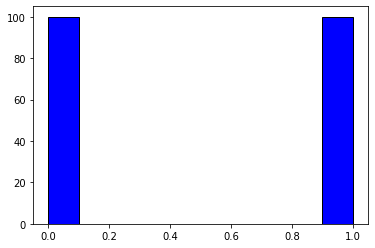

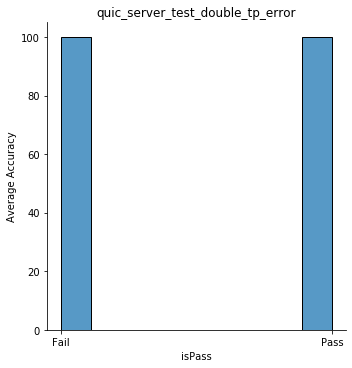

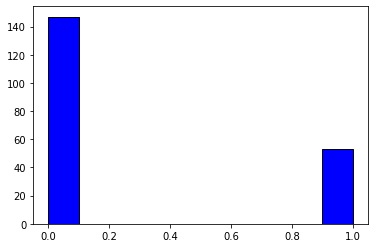

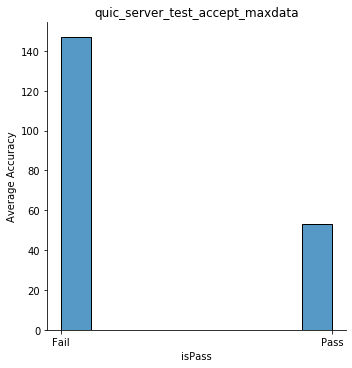

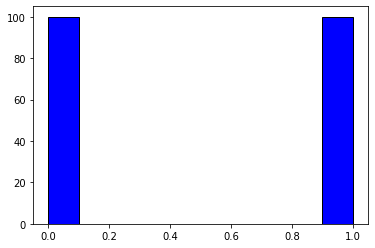

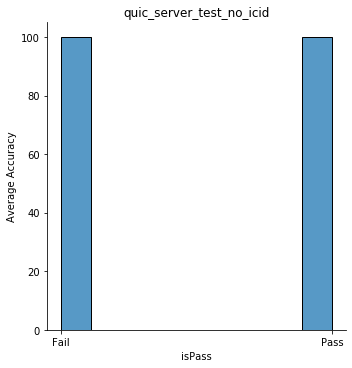

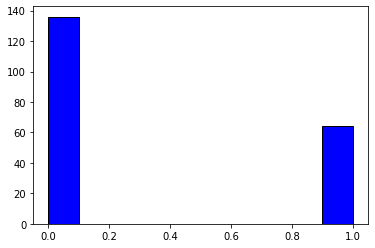

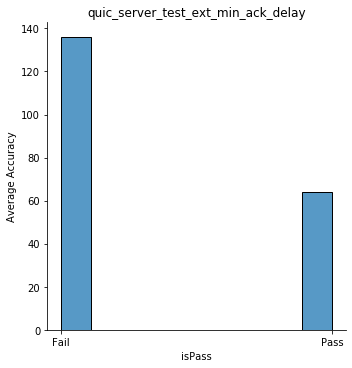

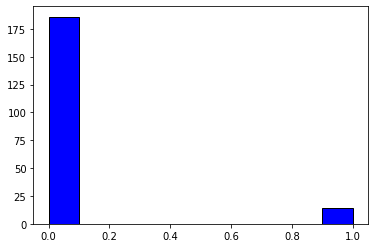

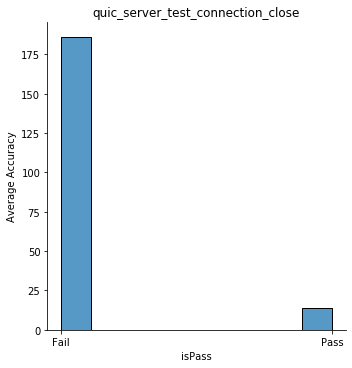

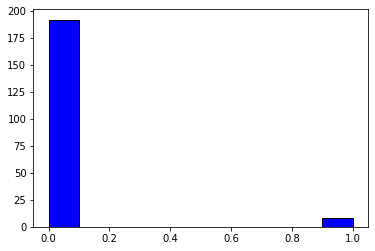

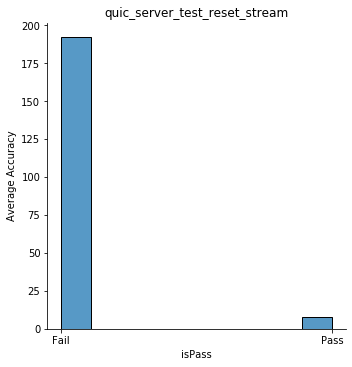

In [8]:
tests = train_df.TestName.unique()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

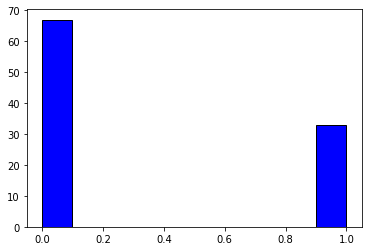

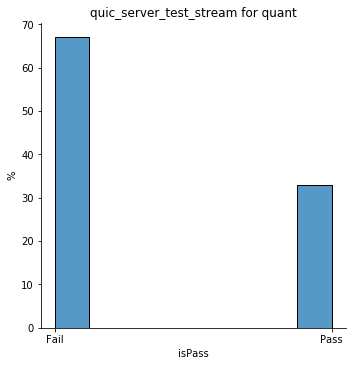

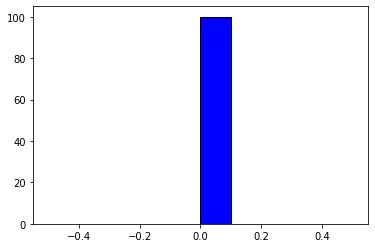

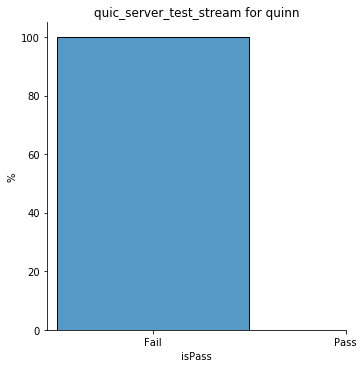

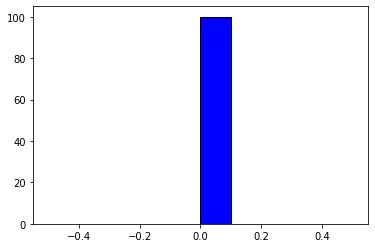

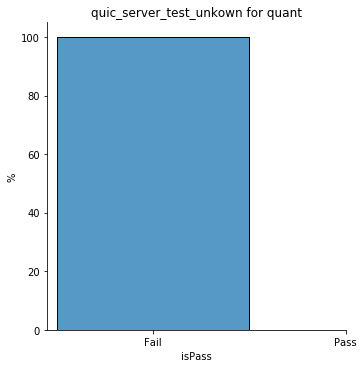

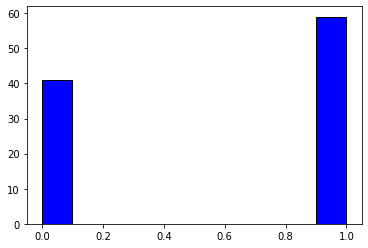

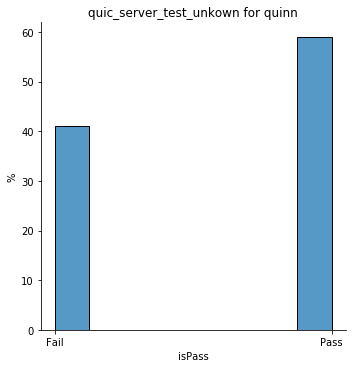

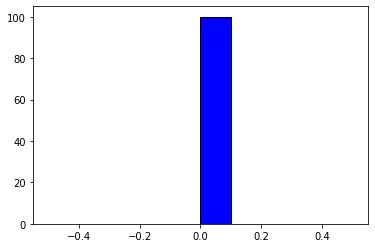

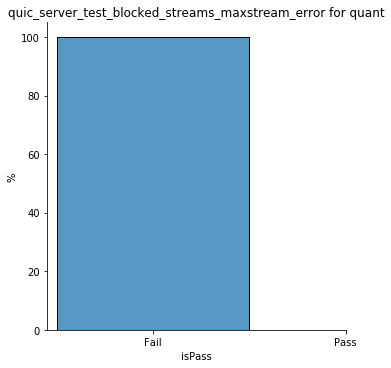

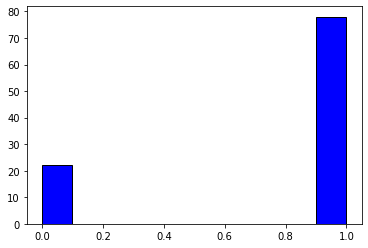

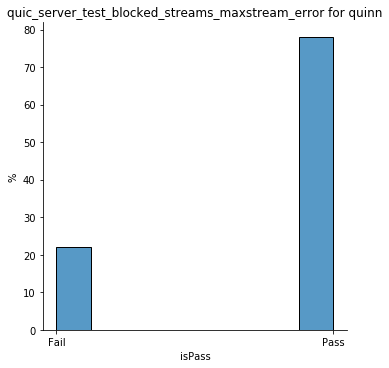

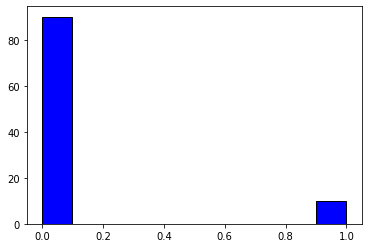

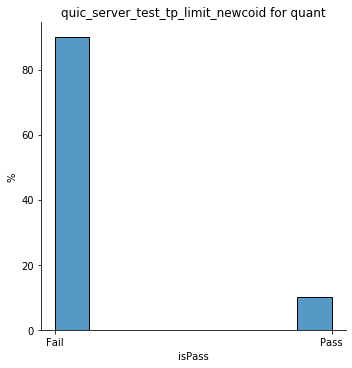

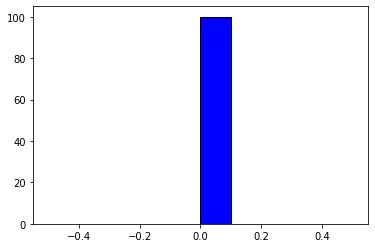

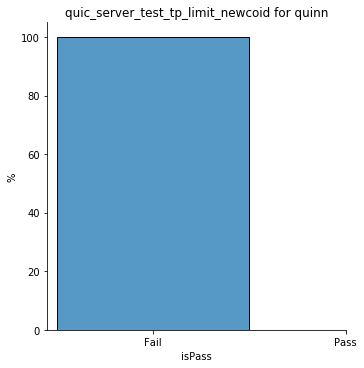

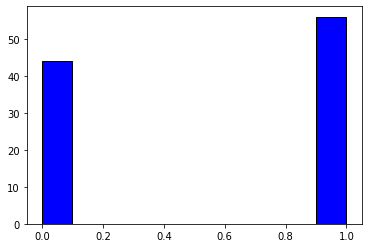

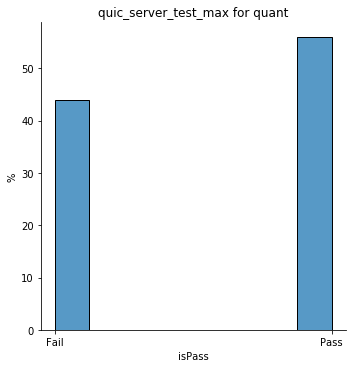

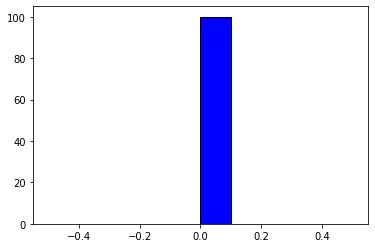

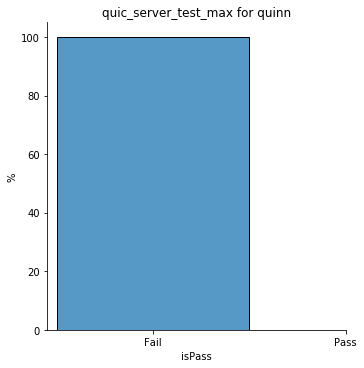

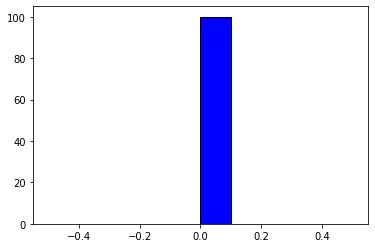

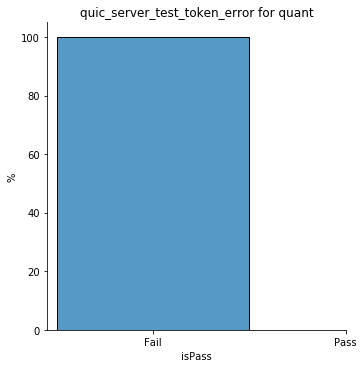

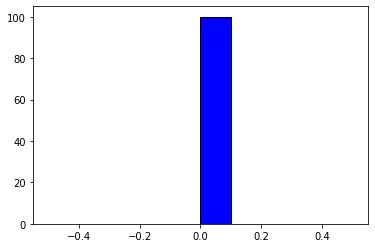

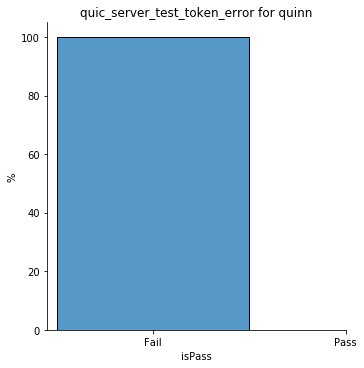

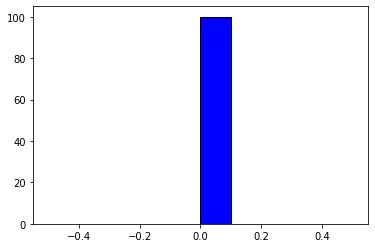

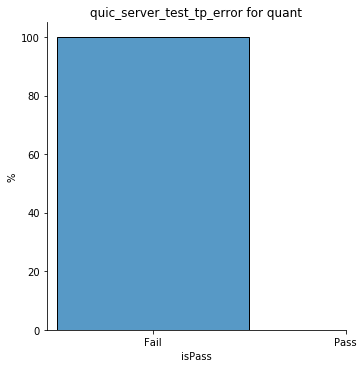

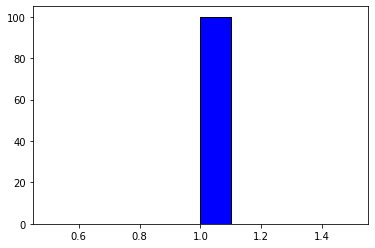

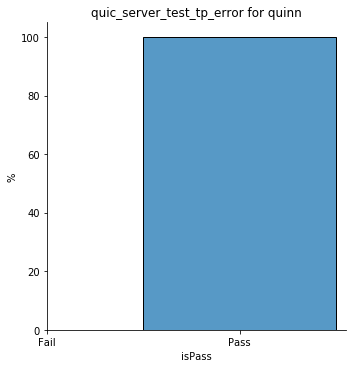

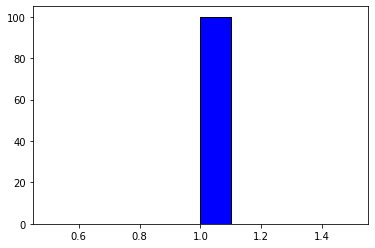

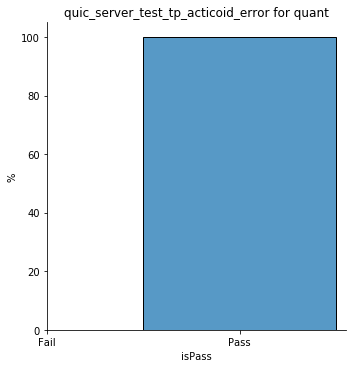

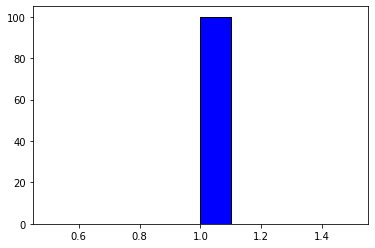

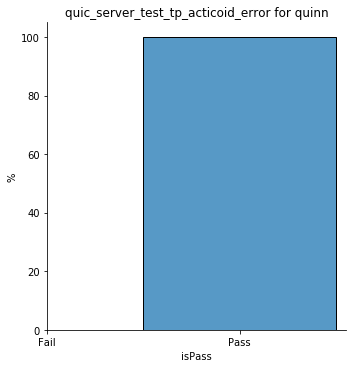

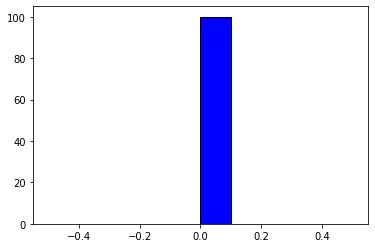

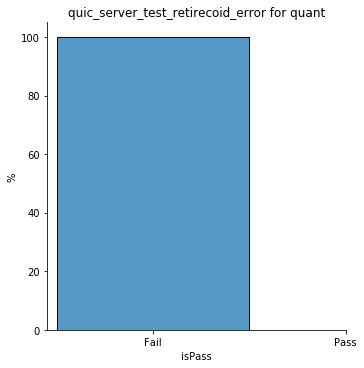

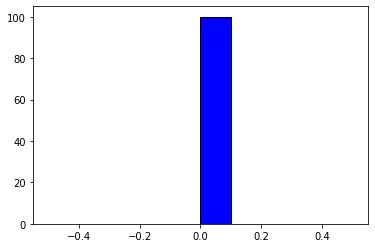

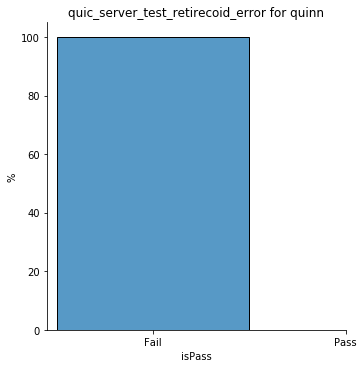

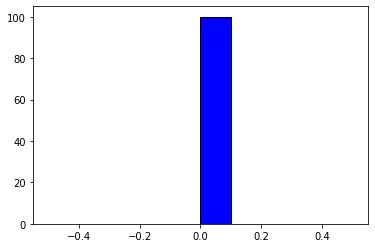

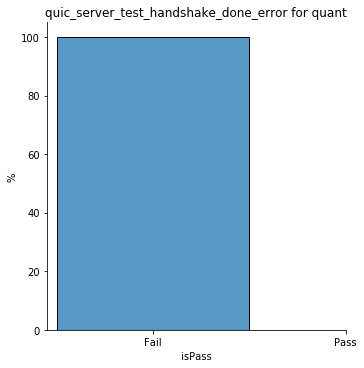

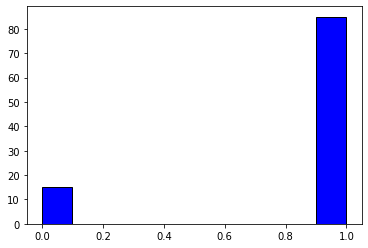

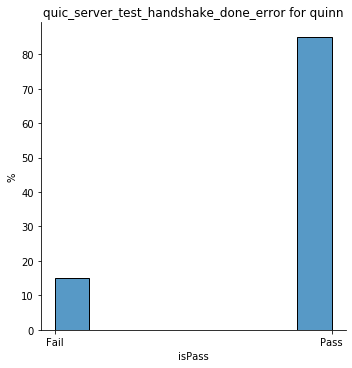

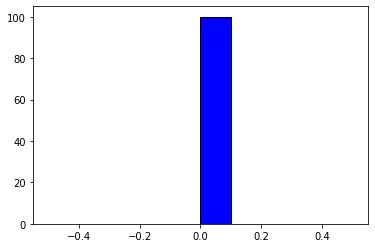

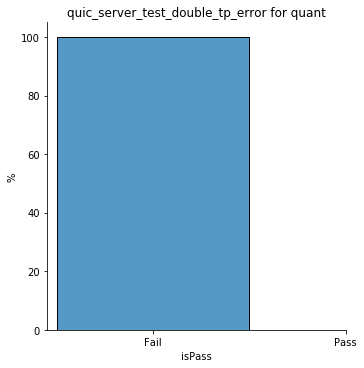

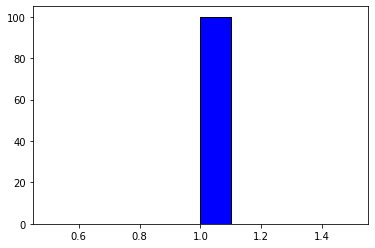

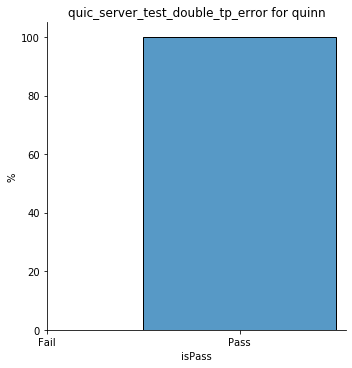

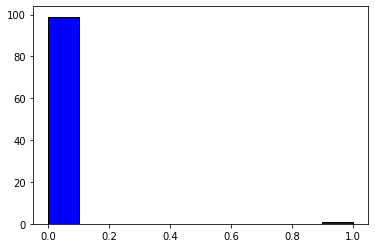

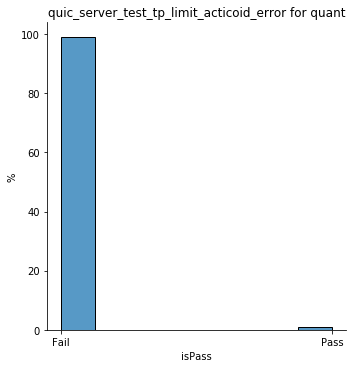

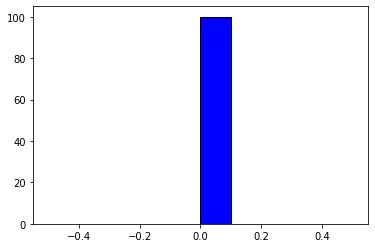

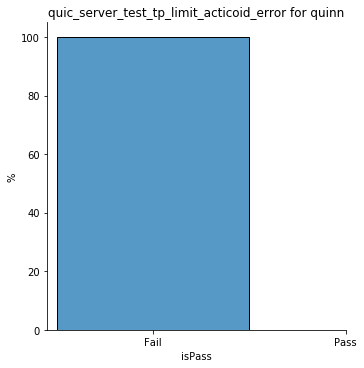

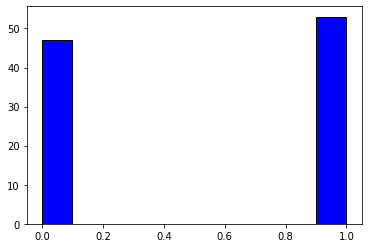

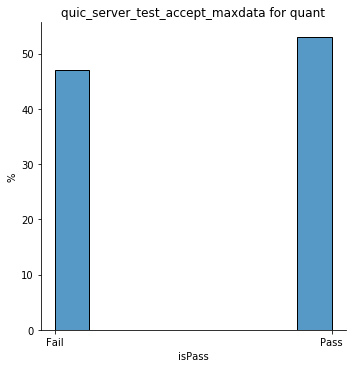

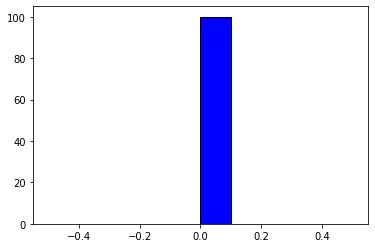

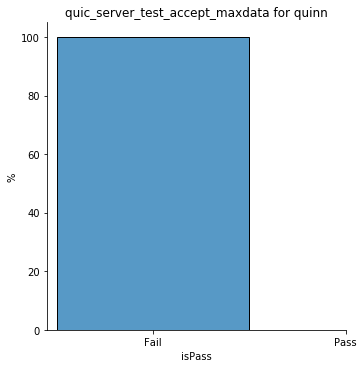

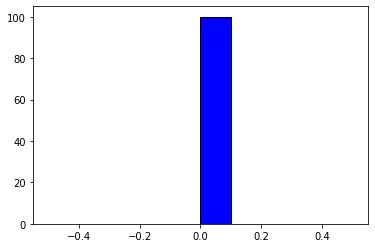

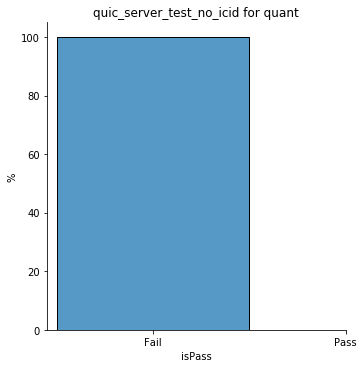

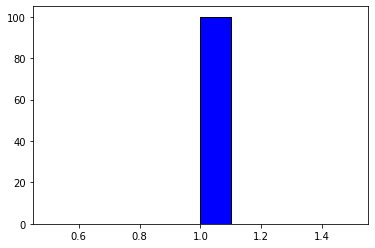

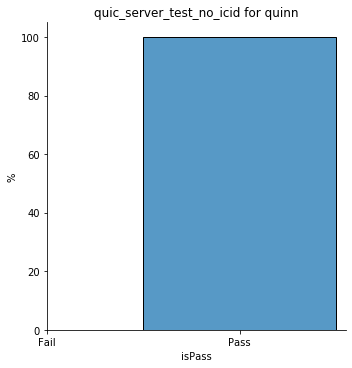

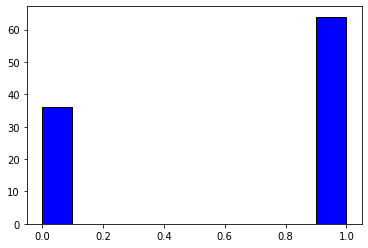

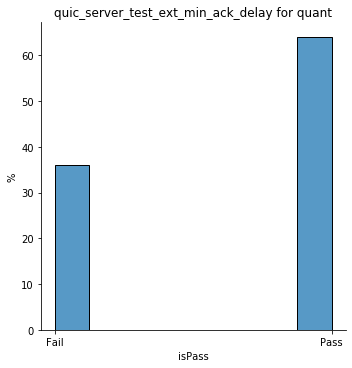

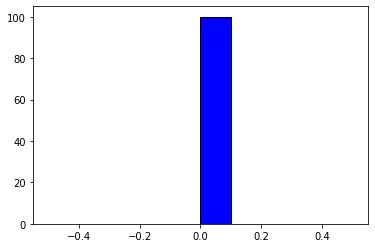

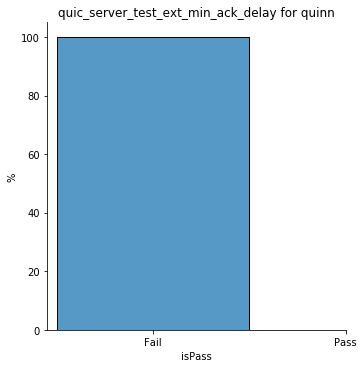

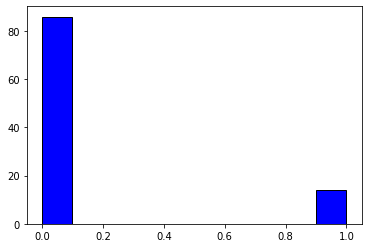

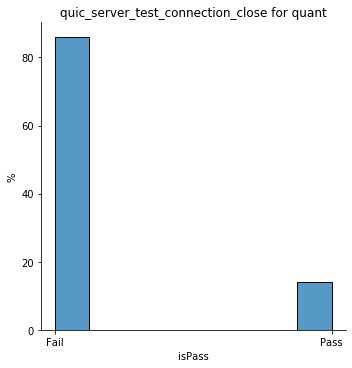

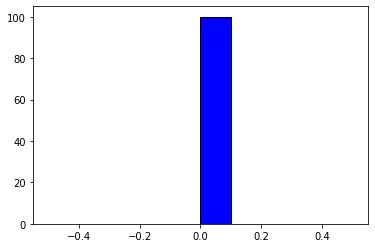

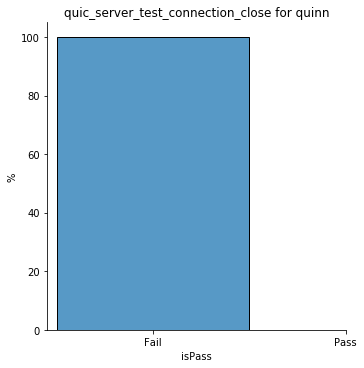

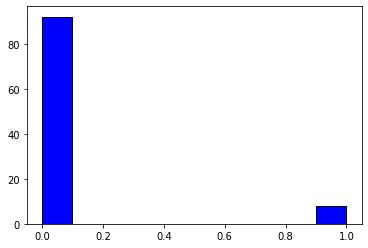

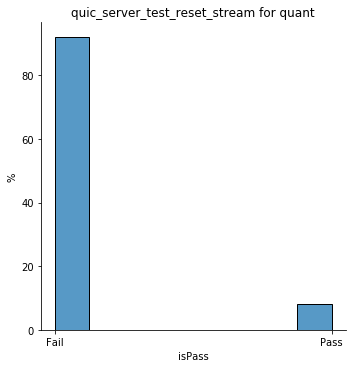

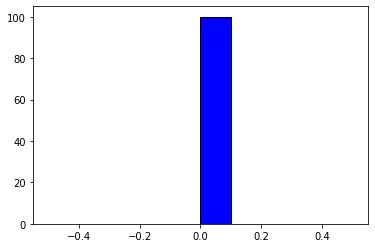

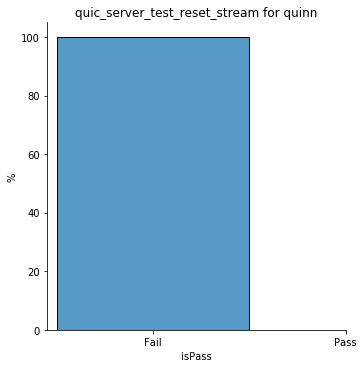

In [58]:
tests = train_df.TestName.unique()

servers = train_df.Implementation.unique() #['lsquic', 'quinn',  'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.displot(subsubdf['isPass'], kde=False)
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()
    

In [15]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

quant
1600
438.0

quinn
1600
722.0



In [16]:
for t in tests: #servers:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers: # tests:
        ssubdf = subdf.loc[subdf['Implementation'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

quic_server_test_stream
quant
100
33.0

quic_server_test_stream
quinn
100
0.0

quic_server_test_unkown
quant
100
0.0

quic_server_test_unkown
quinn
100
59.0

quic_server_test_blocked_streams_maxstream_error
quant
100
0.0

quic_server_test_blocked_streams_maxstream_error
quinn
100
78.0

quic_server_test_tp_limit_newcoid
quant
100
10.0

quic_server_test_tp_limit_newcoid
quinn
100
0.0

quic_server_test_max
quant
100
56.0

quic_server_test_max
quinn
100
0.0

quic_server_test_token_error
quant
100
100.0

quic_server_test_token_error
quinn
100
100.0

quic_server_test_tp_error
quant
100
0.0

quic_server_test_tp_error
quinn
100
100.0

quic_server_test_tp_acticoid_error
quant
100
100.0

quic_server_test_tp_acticoid_error
quinn
100
100.0

quic_server_test_retirecoid_error
quant
100
0.0

quic_server_test_retirecoid_error
quinn
100
0.0

quic_server_test_handshake_done_error
quant
100
0.0

quic_server_test_handshake_done_error
quinn
100
85.0

quic_server_test_double_tp_error
quant
100
0.0

quic_ser

[0, 1, 1, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 0, 3, 0, 1, 0, 3, 2, 0, 1, 3, 2, 3, 2, 0, 1, 2, 1, 2, 3, 0, 4, 1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 3, 4, 3, 2, 3, 2, 0, 2, 2, 4, 1, 1, 0, 3, 3, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 2, 4, 2, 1, 0, 0, 3, 4, 3, 4, 2, 3, 0, 0, 0, 2, 2, 4, 2, 0]
quic_server_test_stream
quant
['No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_stream.png


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Unrecognized location 'right center'. Falling back on 'upper right'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
'This will raise an exception in 3.3.


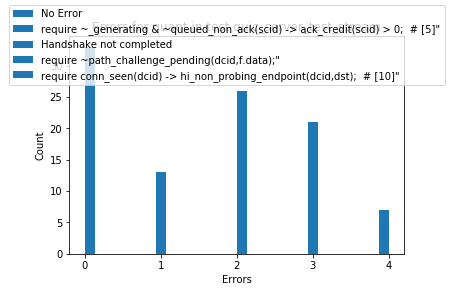

[0, 1, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
quic_server_test_unkown
quant
['require is_frame_encoding_error;"', 'Handshake not completed', 'Segmentation Fault 134']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_unkown.png


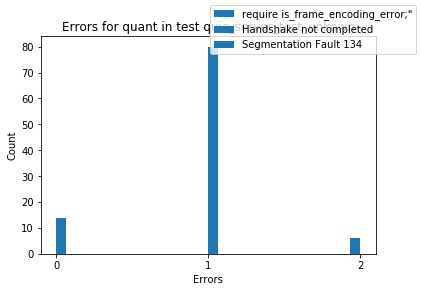

[0, 1, 2, 0, 3, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 2, 1, 3, 2, 1, 1, 3, 1, 1, 0, 3, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 2, 3, 0, 1, 1, 1, 3, 2, 1, 1, 2, 1, 2, 1, 2, 3, 0, 2, 2, 1, 0, 3, 3, 1, 1]
quic_server_test_blocked_streams_maxstream_error
quant
['require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_blocked_streams_maxstream_error.png


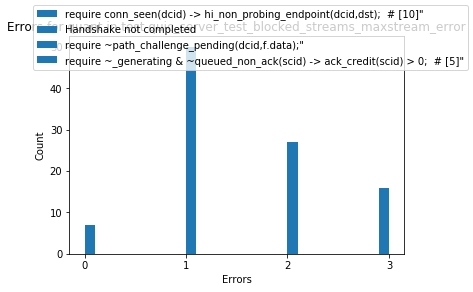

[0, 0, 0, 1, 0, 0, 0, 2, 1, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 4, 4, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 0, 1, 0, 1, 4, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 4, 3, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 3, 0, 1, 3, 1, 0, 2, 0, 2, 2, 3, 2, 1, 0, 2, 0, 3, 3, 0, 3, 2, 3, 0, 2, 1, 0]
quic_server_test_tp_limit_newcoid
quant
['Handshake not completed', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'require ~path_challenge_pending(dcid,f.data);"', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_tp_limit_newcoid.png


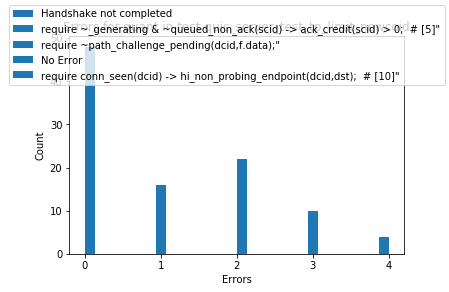

[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 4, 1, 0, 0, 0, 0, 5, 1, 0, 3, 3, 0, 0, 1, 1, 3, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 2, 5, 0, 5, 1, 0, 0, 1, 0, 1, 2, 4, 3, 2, 3, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 3, 0, 5, 1, 0, 1, 0, 1]
quic_server_test_max
quant
['No Error', 'Handshake not completed', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'require ~path_challenge_pending(dcid,f.data);"', 'frame.connection_close:{err_code:0x5}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_max.png


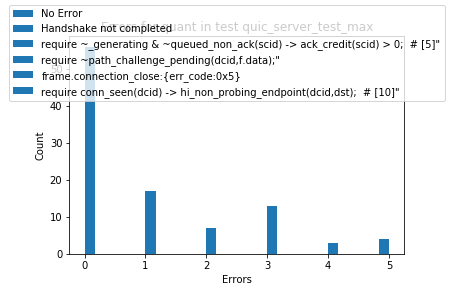

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_token_error
quant
['Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_token_error.png


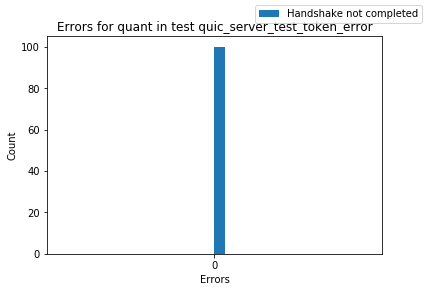

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_tp_error
quant
['server_return_code(1)+timeout']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_tp_error.png


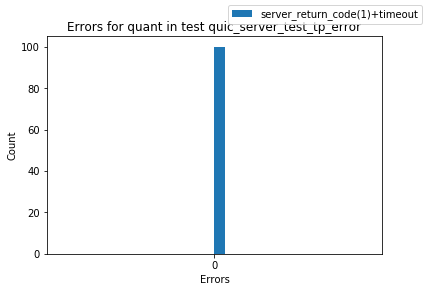

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_tp_acticoid_error
quant
['No Error']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_tp_acticoid_error.png


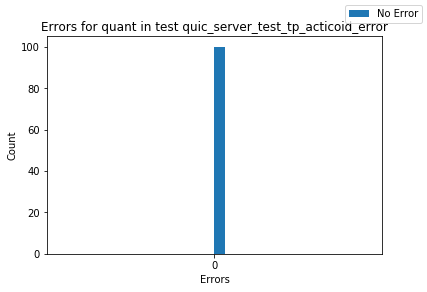

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_retirecoid_error
quant
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_protocol_violation"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_retirecoid_error.png


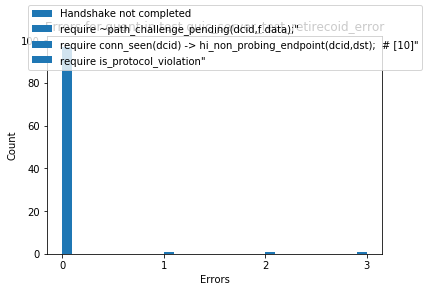

[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
quic_server_test_handshake_done_error
quant
['Handshake not completed', 'require is_protocol_violation"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_handshake_done_error.png


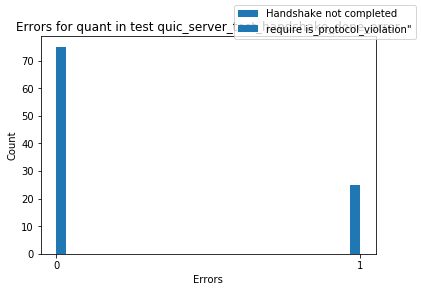

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_double_tp_error
quant
['server_return_code(1)+timeout']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_double_tp_error.png


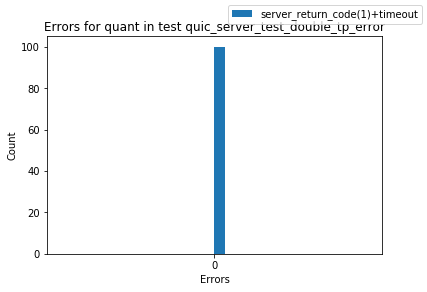

[0, 0, 1, 1, 1, 2, 0, 3, 3, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 4, 0, 1, 1, 1, 0, 3, 1, 1, 3, 1, 5, 6, 1, 0, 0, 1, 6, 4, 1, 1, 1, 0, 1, 0, 6, 1, 3, 1, 1, 0, 2, 4, 1, 4, 0, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 0, 6, 1, 3, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 4, 1]
quic_server_test_accept_maxdata
quant
['require ~path_challenge_pending(dcid,f.data);"', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require conn_total_data(the_cid) > 0;"', 'Handshake not completed', 'frame.connection_close:{err_code:0x5}', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_accept_maxdata.png


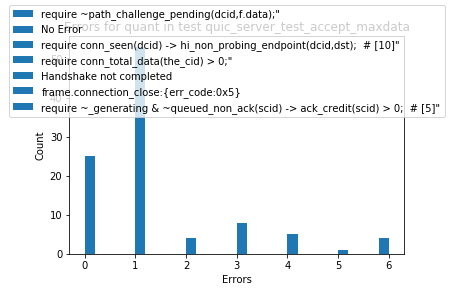

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_no_icid
quant
['server_return_code(1)+timeout']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_no_icid.png


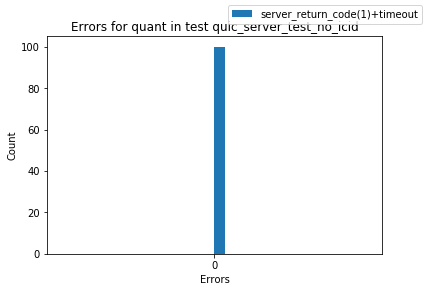

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 1, 0, 2, 3, 1, 0, 3, 1, 0, 0, 0, 3, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0]
quic_server_test_ext_min_ack_delay
quant
['No Error', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_ext_min_ack_delay.png


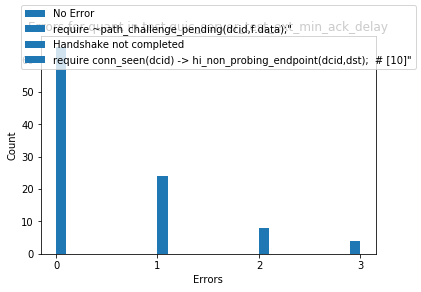

[0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 3, 0, 0, 0, 4, 4, 4, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 4, 5, 0, 1, 5, 5, 0, 0, 0, 0, 6, 2, 0, 0, 6, 0, 2, 0, 0, 0, 5, 0, 4, 6, 0, 5, 2, 6, 0, 6, 0, 6, 0, 2, 0, 6, 6, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
quic_server_test_connection_close
quant
['Handshake not completed', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'No Error', 'Segmentation Fault 134', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require ~draining_pkt_sent(scid) & queued_close(scid);"', 'require ~path_challenge_pending(dcid,f.data);"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_connection_close.png


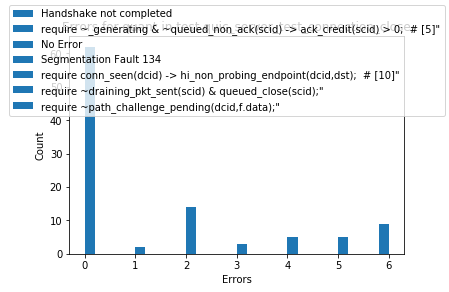

[0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 2, 0, 0, 3, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 1, 0, 5, 0, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 0, 1, 0]
quic_server_test_reset_stream
quant
['frame.connection_close:{err_code:0x5}', 'Handshake not completed', 'No Error', 'require ~path_challenge_pending(dcid,f.data);"', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quant_in_test_quic_server_test_reset_stream.png


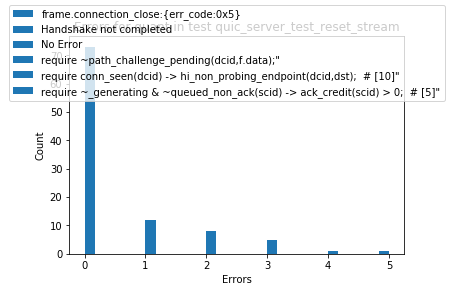

[0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1]
quic_server_test_stream
quinn
['require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'require ~path_challenge_pending(dcid,f.data);"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_stream.png


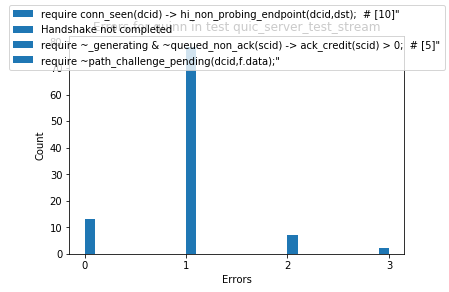

[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2]
quic_server_test_unkown
quinn
['No Error', 'Handshake not completed', 'require is_frame_encoding_error;"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_unkown.png


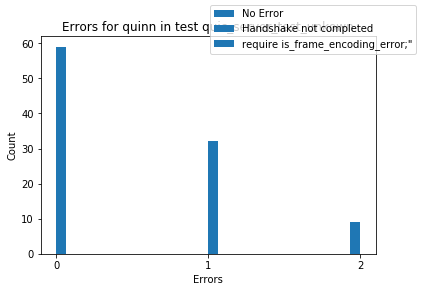

[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
quic_server_test_blocked_streams_maxstream_error
quinn
['No Error', 'Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_blocked_streams_maxstream_error.png


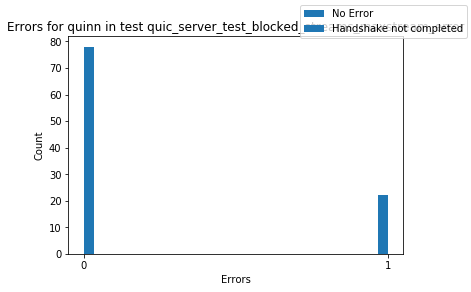

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_tp_limit_newcoid
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_tp_limit_newcoid.png


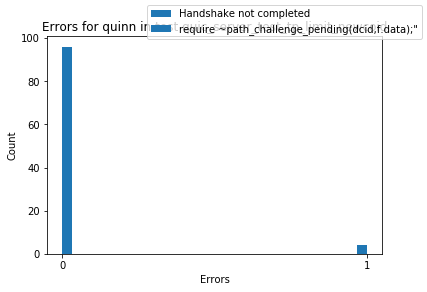

[0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2]
quic_server_test_max
quinn
['Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'require ~path_challenge_pending(dcid,f.data);"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_max.png


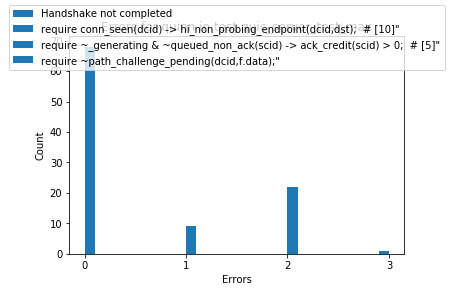

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_token_error
quinn
['Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_token_error.png


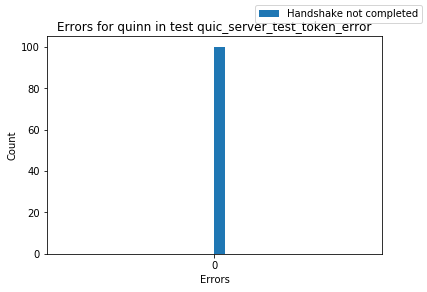

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_tp_error
quinn
['No Error']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_tp_error.png


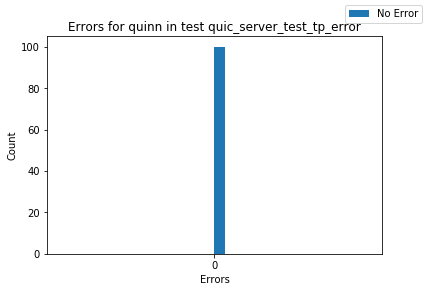

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_tp_acticoid_error
quinn
['No Error']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_tp_acticoid_error.png


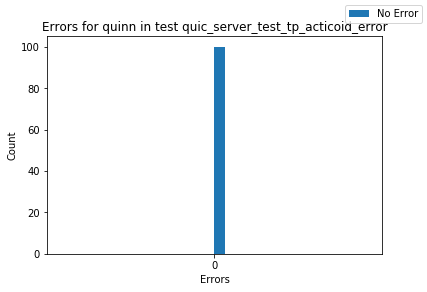

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_retirecoid_error
quinn
['Handshake not completed', 'frame.connection_close:{err_code:0x7}']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_retirecoid_error.png


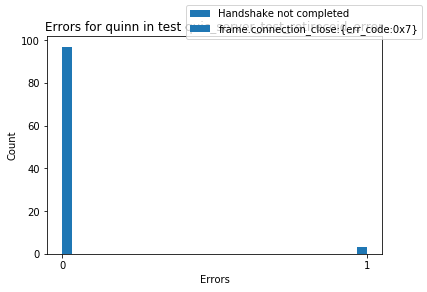

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0]
quic_server_test_handshake_done_error
quinn
['No Error', 'require is_protocol_violation"', 'Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_handshake_done_error.png


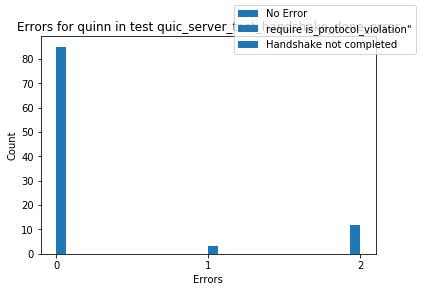

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_double_tp_error
quinn
['No Error']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_double_tp_error.png


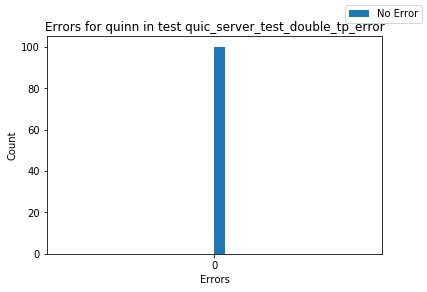

[0, 1, 2, 3, 4, 3, 0, 0, 0, 0, 0, 0, 3, 0, 4, 2, 3, 4, 0, 4, 3, 4, 0, 3, 2, 2, 2, 2, 3, 2, 4, 0, 0, 1, 3, 2, 2, 3, 3, 0, 2, 4, 1, 3, 0, 0, 2, 0, 4, 0, 3, 0, 0, 2, 4, 4, 3, 2, 3, 4, 2, 4, 4, 0, 1, 3, 2, 2, 2, 4, 2, 0, 0, 1, 3, 3, 0, 2, 4, 4, 4, 3, 2, 2, 0, 3, 2, 0, 2, 3, 4, 0, 4, 1, 2, 1, 0, 0, 4, 4]
quic_server_test_accept_maxdata
quinn
['require conn_total_data(the_cid) > 0;"', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
(0.5, 0.0, 0.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_accept_maxdata.png


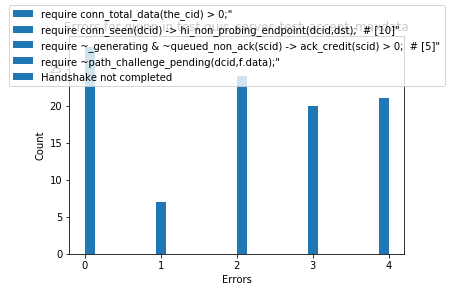

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_no_icid
quinn
['No Error']
GOOD
(0.0, 0.3, 1.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_no_icid.png


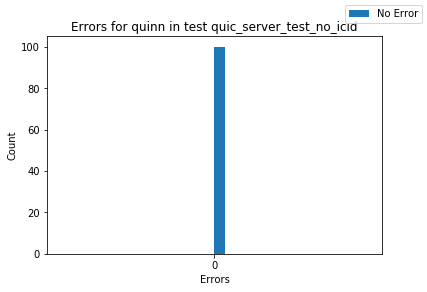

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
quic_server_test_ext_min_ack_delay
quinn
['Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require ~path_challenge_pending(dcid,f.data);"', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
(1.0, 0.40740740740740755, 0.0, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_ext_min_ack_delay.png


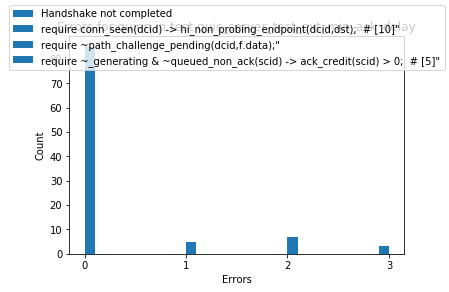

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
quic_server_test_connection_close
quinn
['require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_connection_close.png


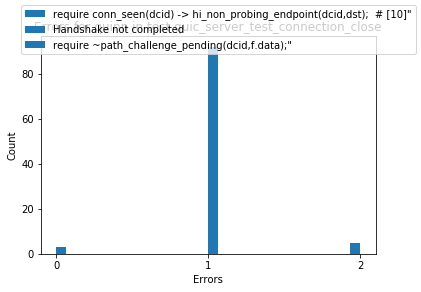

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
quic_server_test_reset_stream
quinn
['require stream_id_allowed(dcid,f.id);  # [6]"', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed']
GOOD
(0.0, 0.3, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.8064516129032256, 1.0, 0.16129032258064513, 1.0)
plot-quant-quinn/errors_for_quinn_in_test_quic_server_test_reset_stream.png


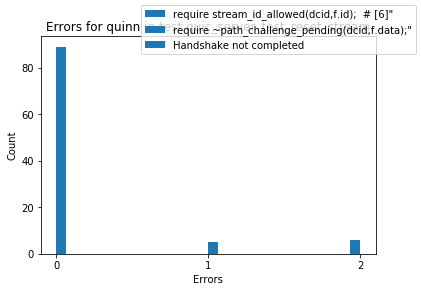

In [13]:
all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for s in servers:
    subdf = train_df.loc[train_df['Implementation'] == s]
    for t in tests:
        subsubdf = subdf.loc[subdf['TestName'] == t]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        all_errors_ind = {all_errors[x]:x for x in range(len(all_errors))}

        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors_ind[row["ErrorIEV"]]
            res.append(ind)
        print(res)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
        all_errors = subsubdf["ErrorsCode"].unique().tolist()        
        # seaborn histogramabs
        # for error in all_errors:
        #     cnt = subsubdf.loc[subsubdf['ErrorsCode'] == error]['ErrorsCode']
            #print(cnt)
        #     sns.displot(x=list(cnt), kde=False)
        
        #sns.displot(x=subsubdf['ErrorsCode'],kde=False ) #,hue="Implementation"
        N, bins, patches = plt.hist(subsubdf['ErrorsCode'], 30)
        #for i in range(0,len(subsubdf['ErrorsCode'].uniques().tolist())):
        print("GOOD")
        # Add labels
        #f, axs = plt.subplots(1,2,
        #              figsize=(9,5),
        #              sharey=True)
        
        cmap = plt.get_cmap('jet')
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        for i in range(0,len(all_errors)):
            c = cmap(0.2*(i+1.0))
            print(c)
            patches[i].set_label(all_errors[i])
            #patches[i].set_facecolor(c)
        
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)))  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(all_errors_ind.values())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')

        #plt.legend(handles=subsubdf['ErrorsCode'], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
        filename = 'plot-quant-quinn/' + "errors_for_" + s + "_in_test_" + t + '.png'
        print(filename)
        fig = plt.gcf()
        fig.legend(loc="right center")
        #plt.tight_layout()
        #fig.set_size_inches(5,5)
        plt.savefig(filename, dpi=fig.dpi*2)
        plt.show()

In [16]:
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_no_icid':
        if 'require initial_source_connection_id.is_set(trans_params(scid));  # [5]"' in row["ErrorIEV"]:
            train_df.drop(i,0,inplace=True)

In [78]:
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_stream']
subsubdf = subdf.loc[subdf['Implementation'] == 'quant']
print(subsubdf.loc[subsubdf["ErrorIEV"] == 'require ~path_challenge_pending(dcid,f.data);"']["OutputFile"][133][-50:]) #[772][-50:]
#print(subsubdf.loc[subsubdf['TestName'] == 'quic_server_test_stream']["OutputFile"][67][-50:])

server-result/temp/22/quic_server_test_stream0.iev


In [19]:
tests = train_df.TestName.unique()

subdf = train_df.loc[train_df['Implementation'] == 'quinn']
for t in tests:
    print(t)
    errors = {}
    subsubdf = subdf.loc[subdf['TestName'] == t]
    for i, row in subsubdf.iterrows():
        err = row['ErrorIEV']
        if err in errors:
            errors[err] = errors[err] + 1
        else :
            errors[err] = 1
    print(errors)

quic_server_test_stream
{'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"': 13, 'Handshake not completed': 78, 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"': 7, 'require ~path_challenge_pending(dcid,f.data);"': 2}
quic_server_test_unkown
{'No Error': 59, 'Handshake not completed': 32, 'require is_frame_encoding_error;"': 9}
quic_server_test_blocked_streams_maxstream_error
{'No Error': 78, 'Handshake not completed': 22}
quic_server_test_tp_limit_newcoid
{'Handshake not completed': 96, 'require ~path_challenge_pending(dcid,f.data);"': 4}
quic_server_test_max
{'Handshake not completed': 68, 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"': 9, 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0;  # [5]"': 22, 'require ~path_challenge_pending(dcid,f.data);"': 1}
quic_server_test_token_error
{'Handshake not completed': 100}
quic_server_test_tp_error
{'No Error': 100}
quic_server_test_tp_acticoi